**Навигация по уроку**
1. [Рекурентные автокодировщики](https://colab.research.google.com/drive/1IkEXo9UWYWfHI5Yr62lvDEMboobHgdCG)
2. [Англо-русский переводчик](https://colab.research.google.com/drive/1M9mAMcAANpVaZdiNkNXDb4_WHnC5bFwu)
3. Домашняя работа

В домашней работе вам необходимо выполнить одно из трёх заданий на выбор:

**Задание 1. На 3 балла:**

1. Ваша задача, используя знания текущего урока обучить модель переводить предложения с английского языка на португальский.

2. В качестве словаря для англо-португальского перевода используйте набор данных из параллельных пар предложений на разных языках http://www.manythings.org/anki/ разделенных табуляцией.

3. Расщепите данные на обучающую выборку и выборку для тестирования модели.

4. Продемонстрируйте работу модели на 10 примерах из тестовой выборки. Сформируйте таблицу из трех колонок: английская фраза из тестовой выборки, португальский перевод из тестовой выборки, предсказанный перевод на португальский язык.

**Задание 2. На 4 балла:**

1. Вам необходимо выполнить задание на 3 балла, изменив механизм токенизации.

2. Для этого необходимо самостоятельно познакомиться с BPE-токенизацией (Byte Pair Encoding) и применить ее. Можно использовать как токенизацию по тексту, так и byte-level BPE-токенизацию по байтовым представлениям (именно так происходит токенизация у GPT моделей от OpenAI).

**ВАЖНО**. Даже если вы не планируете делать задание на 4 балла, хотя бы бегло изучите, как работает byte-level BPE-токенизация, именно она позволяет сжимать словарь до всего-лишь ~50k токенов, при том, что с его помощью всё ещё можно выразить любое слово на любом языке мира и даже эмодзи! Тем более Keras уже содержит готовые токенизаторы и довольно неплохое их описание.

**Задание 3. На 5 балла:**

Это творческое задание нацелено на проработку очень важного навыка любого программиста: умение реализовать проект по фрагментам кода от предыдущей команды.

Представьте, что вы пришли в новую компанию и вам дали следующий код, с помощью которого предыдущая команда, генерировала описания к изображениям:

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from keras.models import Model

# загрузка предобученной модели InceptionV3
base_model = InceptionV3(weights='imagenet')
model = Model(base_model.input, base_model.layers[-2].output)

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features

# чтение данных
captions_data_path = 'captions.txt'
images_path = 'images/'

captions = open(captions_data_path, 'r').read().strip().split('\n')
image_ids = []
captions_list = []
for line in captions:
    img_id, caption = line.split('\t')
    image_ids.append(img_id)
    captions_list.append(caption)

# токенизация
caption_tokenizer = Tokenizer()
caption_tokenizer.fit_on_texts(captions_list)
caption_sequences = caption_tokenizer.texts_to_sequences(captions_list)
caption_word_index = caption_tokenizer.word_index

# паддинг последовательностей
max_len_caption = max([len(txt) for txt in caption_sequences])

decoder_input_data = pad_sequences(caption_sequences, maxlen=max_len_caption, padding='post')

# смещение на один токен вправо для decoder_target_data
decoder_target_data = np.zeros((len(captions_list), max_len_caption, len(caption_word_index) + 1), dtype='float32')
for i, seqs in enumerate(caption_sequences):
    for t, token in enumerate(seqs):
        if t > 0:
            decoder_target_data[i, t - 1, token] = 1.0

# экстракция признаков изображений
image_features = np.zeros((len(image_ids), 2048))
for i, img_id in enumerate(image_ids):
    img_path = images_path + img_id
    image_features[i] = extract_features(img_path, model)

# гиперпараметры
latent_dim = 256
num_decoder_tokens = len(caption_word_index) + 1

# вход для признаков изображения
image_input = Input(shape=(2048,))

# вход для декодера
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[image_input, image_input])
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# модель Seq2Seq
model = Model([image_input, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([image_features, decoder_input_data], decoder_target_data, batch_size=64, epochs=30, validation_split=0.2)

Ваша задача, как тимлида проекта, самостоятельно, не прибегая к помощи куратора:
1. Разобраться в работе кода.
2. Найти датасет с изображениями и подписи к ним.
3. Обучить модель по картинкам делать описание.
4. Продемонстрировать работу модели.

# Что такое BPE?
**BPE (Byte Pair Encoding)** — это алгоритм сжатия данных, который был адаптирован для задач токенизации в обработке естественного языка (NLP). Его ключевая идея — разбивать текст на часто встречающиеся частицы (субтокены), а не на отдельные слова или символы.

**Основная проблема, которую решает BPE:**

Словарный запас языка огромен (появляются новые слова, склонения, опечатки).

Токенизация на уровне слов (word-level) приводит к гигантскому словарю и проблеме с незнакомыми (OOV) словами.

Токенизация на уровне символов (character-level) создает очень длинные последовательности, с которыми модели сложно работать.

BPE находит золотую середину между словами и символами.

**Как работает алгоритм BPE?**

**1. Этап обучения (построение словаря)**

Цель — на основе большого корпуса текста создать словарь (vocab) самых частых и полезных субтокенов.

**Шаги:**

- Инициализация: Исходный текст разбивается на базовые единицы — обычно на символы. Изначально словарь состоит из всех уникальных символов корпуса.

    Например, слово "low" разбивается на ['l', 'o', 'w'], а "lower" на ['l', 'o', 'w', 'e', 'r'].

- Подсчет частот: Подсчитывается частота всех последовательных пар символов (байт) в тексте.

- Слияние (Merge): Находится и выбирается самая частая пара символов. Эта пара объединяется в новый символ (субтокен) и добавляется в словарь.

    Например, если пара ('e', 'r') встречается чаще всего, мы создаем новый токен 'er'. Теперь слово "lower" будет токенизировано как ['l', 'o', 'w', 'er'].

- Повторение: Шаги 2 и 3 повторяются много раз (например, 10,000 или 50,000 раз). На каждом шаге сливается самая частая пара, увеличивая словарь.

    Следующей самой частой парой может быть ('l', 'o') -> создаем 'lo'.

    Потом ('lo', 'w') -> создаем 'low'.

    Теперь у нас в словаре есть токен 'low', и слово "low" будет представлено как один токен, а не три.

Процесс повторяется до тех пор, пока не будет достигнут желаемый размер словаря (например, 10k, 30k, 50k токенов).

**Итог обучения:** У нас есть обученный словарь (vocab) и список правил слияния (merge rules).

**2. Этап кодирования (токенизация нового текста)**
Когда мы хотим токенизировать новое, невиданное ранее слово, мы:

    Разбиваем его на символы (как на старте обучения).

    Последовательно применяем все выученные правила слияния, начиная с самых частых.

    Пытаемся "склеить" символы в самые длинные возможные токены из нашего словаря.

**Пример:** Наш словарь обучен и содержит токены: 'low', 'er', 'est', а также отдельные буквы.

    Слово: "lowest"

    Разбиваем на символы: ['l', 'o', 'w', 'e', 's', 't']

    Применяем правила:

    Видим пару 'e' и 's' -> но у нас нет правила для es, есть для er и est. Пропускаем.

    Видим пару 's' и 't' -> у нас есть токен 'est', но он требует e+s+t. Пока не можем.

    Ищем самые длинные известные токены. Находим 'low'. Объединяем: ['low', 'e', 's', 't']

    Далее, находим токен 'est'. Объединяем: ['low', 'est']

**Результат:** слово "lowest" представлено двумя токенами: ['low', 'est'].

**Ключевые преимущества BPE**

- **Эффективность против OOV (Out-Of-Vocabulary):** Модель может обработать практически любое слово, разбив его на известные субтокены. Даже с опечаткой: "loooove" может стать ['l', 'ooo', 've'].

- **Компактный словарь:** Размер словаря фиксирован и задается заранее. Он намного меньше, чем словарь word-level токенизации, но при этом токенизирует текст в более короткие последовательности, чем character-level.

- **Интуитивная интерпретируемость:** Субтокены часто несут смысл: суффиксы (-ing, -est), приставки (un-, pre-), корни слов. Это лучше, чем полностью случайные последовательности символов.

**Где используется?**

Практически во всех современных LLM:

- **OpenAI** (семейство GPT) используют его модификацию (например, tiktoken).

- **BERT** и его потомки используют WordPiece — очень похожий алгоритм, отличающийся mainly критерием выбора пар для слияния.

- **SentencePiece** — популярная библиотека от Google, которая реализует BPE и другие методы, работая напрямую с raw text (учитывая пробелы и не требувая предварительного разделения на слова).

# Разбор кода

## Импорты

In [ ]:
# работа с датасетом и данными
import numpy as np
import pandas as pd

# модель и слои керас
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Dropout

# предобработка текста
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# модель для выделения фич из картинок
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# предобработка изображений
from keras.preprocessing import image

from keras.models import Model # дубль

## Модель InceptionV3
Далее создается экземпляр модели, предобученной на `imagenet`, которая выделяет представления из изображений, подаваемых в нее. Вывод данных из модели происходит со 2 с конца слоя.

Функция извлечения принимает путь к картинке и экземпляр модели.

    Загружает картинку в размере `(299, 299)` ->

    создает из нее массив ->

    добавляет размерность батча `(1, height, width, channels)` ->

    подготавливает массив (нормализует) к подаче в слое preprocess_input ->

    модель извлекает фичи ->

которые функция возвращает в виде плотного вектора

In [ ]:
# загрузка предобученной модели InceptionV3
base_model = InceptionV3(weights='imagenet')
feature_extraction_model = Model(base_model.input, base_model.layers[-2].output)

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = feature_extraction_model.predict(x, verbose=0)
    return features

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Чтение описаний
Задаем путь до файла, где хранятся данные об изображении и подписи к нему в .txt и путь до папки с изобраджениями.

Открываем этот .txt очищаем концы файла и разделеняем по символу ->

Из каждой строки извлекаем img_id и captions и раскидываем по соответствующим спискам.



Судя по названиям папок и файлов, использовался датасет Flickr 8k, который можно найти на
https://www.kaggle.com/datasets/adityajn105/flickr8k/data

Предварительно загрузим его.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flickr8k


In [ ]:
# чтение данных
captions_data_path = path + '/captions.txt'
images_path = path + '/Images/'

captions = open(captions_data_path, 'r').read().strip().split('\n')[1:]
image_ids = []
captions_list = []
for line in captions:
    img_id, caption = line.split(',', 1)
    image_ids.append(img_id)
    captions_list.append(caption.lower())

In [ ]:
print('Пример image_ids: ', image_ids[:5])
print('Пример captions_list: ', captions_list[:5])

Пример image_ids:  ['1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg', '1000268201_693b08cb0e.jpg']
Пример captions_list:  ['a child in a pink dress is climbing up a set of stairs in an entry way .', 'a girl going into a wooden building .', 'a little girl climbing into a wooden playhouse .', 'a little girl climbing the stairs to her playhouse .', 'a little girl in a pink dress going into a wooden cabin .']


### Проверка датасета

In [ ]:
import os

# список всех файлов, реально существующих в папке изображений
available_images = set(os.listdir(images_path))

missing_images = []
extra_images   = []

for img_id in image_ids:
    if img_id not in available_images:
        missing_images.append(img_id)

# на всякий случай проверим, нет ли файлов в папке, которых нет в captions.txt
captioned_images = set(image_ids)
for img_file in available_images:
    if img_file not in captioned_images:
        extra_images.append(img_file)

print(f"Всего записей в captions.txt: {len(image_ids)}")
print(f"Найдено файлов в папке: {len(available_images)}")
print(f"Отсутствуют в папке: {len(missing_images)}")
print(f"Лишние в папке: {len(extra_images)}")

# если есть пропавшие примеры, вывести первые 10
if missing_images:
    print("\nПримеры отсутствующих файлов:", missing_images[:10])


Всего записей в captions.txt: 40455
Найдено файлов в папке: 8091
Отсутствуют в папке: 0
Лишние в папке: 0


## Токенизатор
Создаем токенизатор и обучаем его на тексте. Токенизируем описания из `captions_list`, получаем `caption_sequences` - токенизированные последовательности, и `caption_word_index` - словарь и индексы

In [ ]:
# апгрейд оригинала
# Добавляем  start и end токены
start_token = '<start>'
end_token = '<end>'

# токенизация
caption_tokenizer = Tokenizer()
caption_tokenizer.fit_on_texts(captions_list)
caption_sequences = caption_tokenizer.texts_to_sequences(captions_list)
caption_word_index = caption_tokenizer.word_index

# апгрейд оригинала
# Добавляем их в словарь
caption_word_index[start_token] = len(caption_word_index) + 1
caption_word_index[end_token] = len(caption_word_index) + 1

# апгрейд оригинала
# Обновляем последовательности с добавлением start и end токенов
caption_sequences_with_tokens = []
for seq in caption_sequences:
    caption_sequences_with_tokens.append([caption_word_index[start_token]] + seq + [caption_word_index[end_token]])

In [ ]:
# Проверьте распределение токенов в данных
from collections import Counter

# Анализ частоты токенов
all_tokens = [token for seq in caption_sequences for token in seq]
token_counts = Counter(all_tokens)
print("Наиболее частые токены:", token_counts.most_common(10))

# Проверьте специальные токены
print("Start token index:", caption_word_index.get(start_token, 'Not found'))
print("End token index:", caption_word_index.get(end_token, 'Not found'))

Наиболее частые токены: [(1, 62992), (2, 18986), (3, 18419), (4, 10745), (5, 9345), (6, 8862), (7, 8138), (8, 7765), (9, 7274), (10, 6723)]
Start token index: 8494
End token index: 8495


## Паддинг
Указываем максимальную длинну описания, найденного в токенизированных последовательностях.

В `decoder_input_data` заполняем концы всех последовательностей меньше максимальной длинны, чтобы выровнять пакеты.

In [ ]:
# паддинг последовательностей
max_len_caption = max([len(txt) for txt in caption_sequences_with_tokens])

decoder_input_data = pad_sequences(
    caption_sequences_with_tokens,
    maxlen=max_len_caption,
    padding='post',
    value=0
    )

## Целевой массив со смещением

Создаем массив нулей `decoder_target_data` с размерностью `(x, y, z)`, где

x - длинна `captions_list`, количество изображений

y - размер максимальной подписи `max_len_caption`,

z - длинна словаря `caption_word_index` +1 (для добавления токена паддинга)

и типом данных `float32`.

Проходим по `caption_sequences` и выделяем пронумерованные токены, по которым так же проходим и, начиная со второго токена, задаем значение 1 (для OHE), помечая целевой токен в предсказании модели. Со второго токена - т.к. первый токен для подачи будет токен начала генерации, либо токен, полученный на предыдущем шаге генерации.

**Сдвиг на один шаг:** Целевой токен token в позиции t исходной последовательности становится целью для предсказания на шаге t-1 в декодере. Это и есть смещение.

**One-Hot Encoding:** Каждый временной шаг в decoder_target_data — это one-hot вектор, где активен (равен 1) только один элемент — тот, который модель должна предсказать на этом шаге.

**Неполные последовательности:** Так как наши примеры были короче max_len_caption, оставшиеся шаги заполнены нулями. На этих шагах модель будет учиться предсказывать токен 0 (который обычно является паддингом или маской), то есть "ничего".

**Пропуск первого токена:** первый токен каждой последовательности никогда не становится целью. Это правильное поведение, так как цель декодера — предсказать следующее слово. Первое слово декодер получает на вход как часть входных данных (обычно как начальный токен `<start>`).

In [ ]:
# смещение на один токен вправо для decoder_target_data
decoder_target_data = np.zeros((len(captions_list), max_len_caption, len(caption_word_index) + 1), dtype='float32')
for i, seqs in enumerate(caption_sequences):
    for t, token in enumerate(seqs):
        if t > 0:
            decoder_target_data[i, t - 1, token] = 1.0

### Обновление кода для input и target с токенами

In [ ]:
# Создаем маску для игнорирования паддинга при вычислении потерь
sample_weight = np.zeros((len(decoder_input_data), max_len_caption), dtype='float32')
for i, seq in enumerate(decoder_input_data):
    # Находим позицию первого нуля (начала паддинга)
    padding_start = np.where(seq == 0)[0]
    if len(padding_start) > 0:
        padding_start = padding_start[0]
    else:
        padding_start = len(seq)
    # Устанавливаем вес 1.0 для всех значимых токенов
    sample_weight[i, :padding_start] = 1.0

# Подготовка decoder_target_data (со сдвигом на один токен)
decoder_target_data = np.zeros((len(decoder_input_data), max_len_caption), dtype='float32')
for i, seq in enumerate(caption_sequences_with_tokens):
    for t in range(1, len(seq)):
        if t < max_len_caption:
            decoder_target_data[i, t-1] = 1.0

Мы создали нулевой массив и заполнили его единицами там, где в последовательностях имеются токены слов, и нулями для паддингов - эта маска будет использована при вычислении функции потерь.

Так же немного изменили способ сдвига, теперь он создает массив нулей размером `(x, y)` вместо `(x, y,z)` для совместимости с функцией ошибки `sparse_categorical_crossentropy`, а так же там есть защита от выхода за максимальную длинну последовательности и учит модель обрабатывать токен завершения.

**Причина смены формы данных - Различие между функциями потерь:**

1. **`categorical_crossentropy`**

    **Ожидаемый формат:** One-hot encoding

    **Пример:** Для 3 классов и правильного класса 2: [0, 0, 1]

    **Размерность:** (batch_size, sequence_length, num_classes)

    **Принцип работы:** Сравнивает распределение вероятностей на выходе модели с one-hot вектором правильного класса

2. **`sparse_categorical_crossentropy`**

    **Ожидаемый формат:** Целочисленные индексы классов

    **Пример:** Для 3 классов и правильного класса 2: 2

    **Размерность:** (batch_size, sequence_length)

    **Принцип работы:** Сравнивает распределение вероятностей на выходе модели с индексом правильного класса

## Экстракция признаков

Создаем массив нулей размером `(x, y)`, где

x - количество изображений,

y - количество признаков на каждое изображение

Проходим по пронумерованным изображениям, в функции `extract_features` извлекаем с помощью экземпляра модели `InceptionV3`, определенного ранее, признаки и заполняем ими массив `image_features`

In [ ]:
# экстракция признаков изображений
image_features = np.zeros((len(image_ids), 2048))
for i, img_id in enumerate(image_ids):
    img_path = images_path + img_id
    image_features[i] = extract_features(img_path, model)

У нас в текстовом файле для каждого изображения созданы 5 описаний, если запустить цикл без использования кеша, то обработка займет около 30-40 минут. Можно оптимизировать этот процесс с помощью кеша.

In [ ]:
features_cache = {}

In [ ]:
image_features = np.zeros((len(image_ids), 2048))

for i, img_id in enumerate(image_ids):
    if img_id not in features_cache:
        img_path = images_path + img_id
        features_cache[img_id] = extract_features(img_path, model)
    image_features[i] = features_cache[img_id]

In [ ]:
# Сохраняем, если они понадобятся еще раз
np.save("features_cache.npy", features_cache, allow_pickle=True)

In [ ]:
# Загрузка
features_cache = np.load("features_cache.npy", allow_pickle=True).item()

С кешированием процесс занял 13 минут

## Создание модели для получения описаний из изображений

**Задаем гиперпараметры модели:**

`latent_dim = 256` - размерность для LSTM слоя

`num_decoder_tokens = len(caption_word_index) + 1` - размерность выходного слоя, который будет определять предсказанное слово.

**Определение модели:**

    - Входы:

        `image_input`: вход для признаков изображения (форма: (2048,))
        `decoder_inputs`: вход декодера (последовательности слов, форма: (None,))
    
    - Слой Embedding: преобразует целочисленные индексы слов в плотные векторы размерности `latent_dim`.
    
    - LSTM слой:
        - Инициализируется начальными состояниями (состояние и ячейка) из вектора признаков изображения.
          Мы используем один и тот же вектор `image_input` для обоих начальных состояний (состояния и ячейки).
        - Возвращает всю последовательность выходов (`return_sequences=True`) и последние состояния (но мы их не используем, поэтому присваиваем `_`).
    
    - Полносвязный слой (Dense) с 'softmax': преобразует выход LSTM в вероятности по словарю.

**Компиляция и обучение:**

    - Модель компилируется с оптимизатором 'rmsprop' и функцией потерь 'categorical_crossentropy'.

    - Обучение:
        - Входные данные: [image_features, decoder_input_data]
        - Выходные данные: decoder_target_data
        - Размер батча: 64, количество эпох: 30, validation_split=0.2


In [ ]:
# гиперпараметры
latent_dim = 256
num_decoder_tokens = len(caption_word_index) + 1

# вход для признаков изображения
image_input = Input(shape=(2048,))

# вход для декодера
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[image_input, image_input])
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# модель Seq2Seq
model = Model([image_input, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([image_features, decoder_input_data], decoder_target_data, batch_size=64, epochs=30, validation_split=0.2)

В данном коде есть несколько мест для исправления/улучшения:

- `decoder_lstm` имеет размерность 256, но в `initial_state` получает размерности 2048, что приведет к ошибке.

        Для приведения в соответствие размерностей фич с LSTM
        добавим Dense слои для сжатия.

- Упоминаются смещения для обучающего набора, но отсутствуют токены старта и окончания, чтобы модель стабильно стартовала и заканчивала генерацию.

- Так же для улучшения обучения можно добавить маскирование нулей в эмбединг слой, а так же можно с помощью `sample_weight` указать значимые токены для обратного распростарнения ошибки и пропустить паддинг.

- При использовании функции потерь `categorical_crossentropy` ожидается использование OHE и в паре с большим словарем токенизатора мы получим моментальное переполнение ОЗУ при попытке обучения. Выходом будет использование `sparse_categorical_crossentropy`.
        Для нее нужно будет изменить форму целевых данных.

На этом завершается процесс обучения модели. Чтобы выполнить генерацию для инференса нам нужно перестроить модель.

# Модель для генерации

В новый энкодер мы берем несколько слоев из обучения:
- вход - векторное представление изображения
- выход - данные из Dense(256) слоя для инициализации state_h и state_c в LSTM декодера

Декодер принимает на вход состояния h и c, и стартовый/предыдущий токен ->

прогоняет в эмбединге токен ->

инициализирует LSTM предыдущим состоянием и обрабатывает вектор токена, возвращая output, h и c после обработки ->

output проходит через dense слой для определения текущего токена ->

модель декодера собирается со входом `[входной_токен, состояние_h, состояние_c]` и выходом `[выходной_токен, новое_состояние_h, новое_состояние_c]`

Если при обучении мы не создавали отдельные экземпляры слоев Embedding, LSTM и выходной Dense, а только потом пропускаем через них данные, то в модели для инференса не получится использовать эти слои напрямую вызвав их из обучающей модели.

# Полное выполнение цикла с извлечением представлений

Полностью перенесу все куски с обновлением кода в последовательные ячейки для удобства запуска

In [ ]:
import os
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image

## Экстрактор признаков

In [1]:
def build_feature_extractor():
    base_model = InceptionV3(weights='imagenet')
    model = Model(base_model.input, base_model.layers[-2].output)
    return model

def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features[0]

In [61]:
feature_extractor = build_feature_extractor()

## Подготовка данных

In [45]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

captions_data_path = path + '/captions.txt'
images_path = path + '/Images/'

captions = open(captions_data_path, 'r').read().strip().split('\n')[1:]

image_ids = []
captions_list = []
for line in captions:
    img_id, caption = line.split(',', 1)
    caption = f"<start> {caption} <end>"
    image_ids.append(img_id)
    captions_list.append(caption)

# Токенизатор
caption_tokenizer = Tokenizer(oov_token="<unk>", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n') # Оставляем спецсимволы < и >
caption_tokenizer.fit_on_texts(captions_list)
caption_sequences = caption_tokenizer.texts_to_sequences(captions_list)
word_index = caption_tokenizer.word_index

max_len_caption = max(len(s) for s in caption_sequences)
num_tokens = len(word_index) + 1

# Паддинг входных описаний
decoder_input_data = pad_sequences(caption_sequences, maxlen=max_len_caption, padding='post')

# Decoder target data (смещен на 1)
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]

Path to dataset files: /kaggle/input/flickr8k


In [48]:
captions_list[0]

'<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>'

In [47]:
print('<start>' in caption_tokenizer.word_index)
print('<end>' in caption_tokenizer.word_index)

True
True


## Выделяем признаки экстрактором

In [9]:
features_path = 'image_features.npz'

if os.path.exists(features_path):
    # Загружаем как словарь {filename: feature_vector}
    data = np.load(features_path, allow_pickle=True)
    features_dict = data['features'].item()
else:
    features_dict = {}

    for img_id in image_ids:
        if img_id not in features_dict:  # Кэширование по имени файла
            img_path = os.path.join(images_path, img_id)
            features_dict[img_id] = extract_features(img_path, feature_extractor)

    # Сохраняем словарь
    np.savez_compressed(features_path, features=features_dict)

# Преобразуем словарь в массив
image_features = np.array([features_dict[img_id] for img_id in image_ids])

In [71]:
print(list(features_dict.keys())[:1])
print(list(features_dict.values())[:1])

['1000268201_693b08cb0e.jpg']
[array([0.12277625, 0.3329308 , 0.75272465, ..., 0.21941468, 0.3020851 ,
       0.40279698], dtype=float32)]


## Модель обучения

In [56]:
latent_dim = 256

# Image input (encoder)
image_input = Input(shape=(2048,), name="image_input")
dense_input = Dense(latent_dim, activation='relu') # создаем самостоятельный слой
image_dense = dense_input(image_input)

# Decoder input
decoder_inputs = Input(shape=(None,), name="decoder_input")
embedding_inputs = Embedding(input_dim=num_tokens, output_dim=latent_dim, mask_zero=True) # создаем самостоятельный слой
decoder_embedding = embedding_inputs(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[image_dense, image_dense]) # создаем самостоятельный слой
decoder_dense = Dense(num_tokens, activation='softmax') # создаем самостоятельный слой
outputs = decoder_dense(decoder_outputs)

training_model = Model([image_input, decoder_inputs], outputs)
training_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [57]:
training_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, None, 256) │  2,175,232 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    524,544 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, None,     │    525,312 │ embedding_5[0][0… │
│                     │ 256), (None,      │            │ dense_10[0][0],   │
│                     │ 256), (None,      │            │ dense_10[0][0]    │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, None,      │  2,183,729 │ lstm_5[0][0]      │
│                     │ 8497)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,408,817 (20.63 MB)

 Trainable params: 5,408,817 (20.63 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение

In [58]:
history = training_model.fit(
    [image_features, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    batch_size=64,
    epochs=20,
    validation_split=0.2
)

Epoch 1/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - loss: 5.3072 - val_loss: 4.1304
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 3.9669 - val_loss: 3.6087
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 3.4912 - val_loss: 3.3693
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 3.2513 - val_loss: 3.2576
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 3.0778 - val_loss: 3.1557
Epoch 6/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 2.9585 - val_loss: 3.0780
Epoch 7/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - loss: 2.8612 - val_loss: 3.0476
Epoch 8/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 2.7724 - val_loss: 3.0018
Epoch 9/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 2.7071 - val_loss: 2.9710
Epoch 10/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - loss: 2.6330 - val_loss: 2.9524
Epoch 11/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 2.5784 - val_loss: 2.9389
Epoch 12/20
506/506 ━━━━━━━━━━

## Модель для инференса

In [59]:
# Encoder (image -> initial state)
encoder_model = Model(image_input, image_dense)

# Decoder for inference
inf_decoder_state_input_h = Input(shape=(latent_dim,))
inf_decoder_state_input_c = Input(shape=(latent_dim,))

inf_decoder_inputs = Input(shape=(1,))
inf_embedded = embedding_inputs(inf_decoder_inputs)     # используем слой из обучаемой модели

inf_decoder_outputs, state_h, state_c = decoder_lstm(   # используем слой из обучаемой модели
    inf_embedded,
    initial_state=[inf_decoder_state_input_h, inf_decoder_state_input_c]
)
inf_outputs = decoder_dense(inf_decoder_outputs)        # используем слой из обучаемой модели

decoder_model = Model(
    [inf_decoder_inputs, inf_decoder_state_input_h, inf_decoder_state_input_c],
    [inf_outputs, state_h, state_c]
)

## Функция генерации описания

In [60]:
index_word = {i: w for w, i in word_index.items()}

def generate_caption(img_path, max_length=20):
    feat = extract_features(img_path, feature_extractor).reshape(1, -1)
    state = encoder_model.predict(feat, verbose=0)
    h, c = state, state

    token = caption_tokenizer.word_index['<start>']
    caption = []

    for _ in range(max_length):
        output, h, c = decoder_model.predict([np.array([token]), h, c], verbose=0)
        token = np.argmax(output[0, -1, :])
        word = index_word.get(token, '')
        if word == '<end>' or not word:
            break
        caption.append(word)
    return ' '.join(caption)

## Тестовый образец

In [62]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# вывод картинки
def show_image(image_path):
    """Показать изображение по указанному пути"""
    img = mpimg.imread(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Скрыть оси
    plt.show()

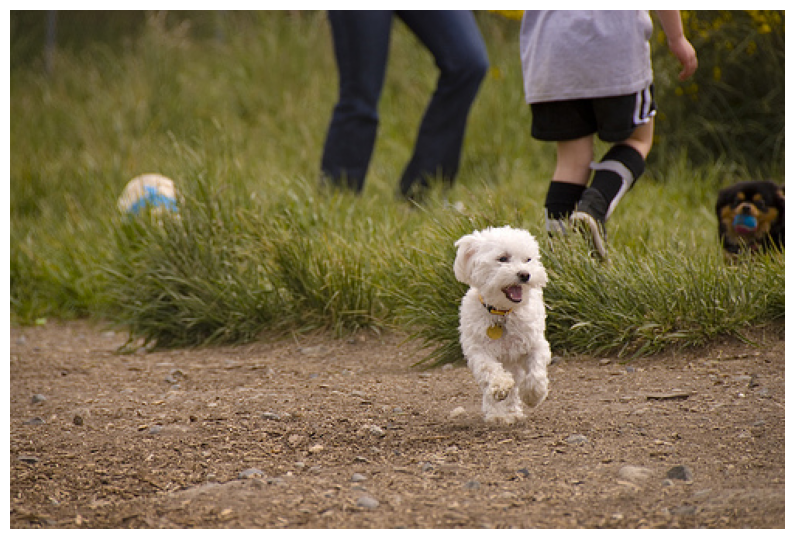

In [65]:
test_image = images_path + np.random.choice(image_ids)
show_image(test_image)

In [66]:
generate_caption(test_image)

'a small white dog is playing with a stick'

In [67]:
def plot_loss(train_loss, val_loss):
    """Функция для построения графиков потерь"""
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

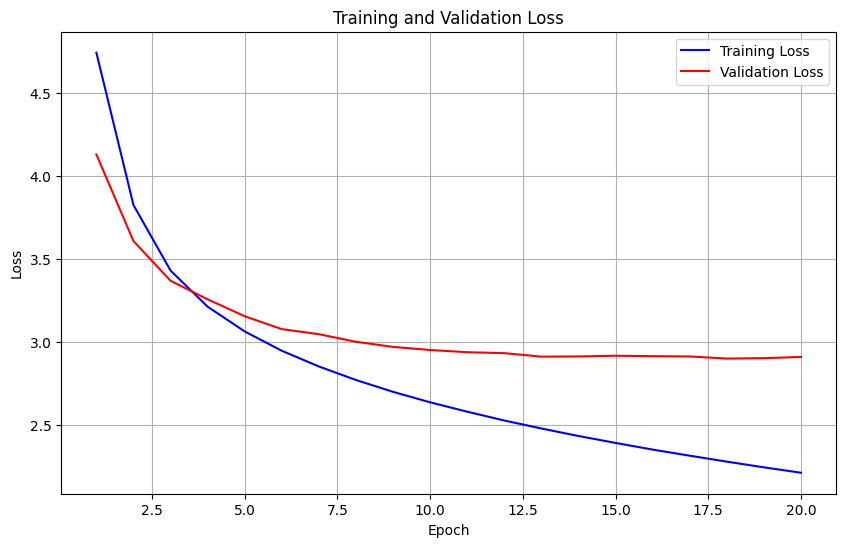

In [69]:
plot_loss(history.history['loss'], history.history['val_loss'])

Плато на валидации показывает, что модель смогла отобрать максимум данных для своего обучения из нашего набора картинок. Чтобы продолжить улучшать показатели, нам понадобится больше разнообразных примеров.

# Итог

Получился вполне адекватный ответ при генерации описания изображения от обученной модели. Хотя должен сказать, что в некоторых случаях модель может путать пол человека, цвета, но в целом способна распознавать объекты, людей, животных и окружение верно, а так же создавать осмысленные описания. Наша модель довольно простая а количество изображений небольшое, чтобы можно было ожидать более качественных описаний. Как вариант улучшения, можно было бы использовать **Beam search:**

- на каждом шаге рассматриваются k самых вероятных последовательностей (beam width = k), а дальше выбирается лучший путь по суммарной вероятности.

- k=3–5 обычно достаточно для captioning.

- Позволяет искать более осмысленные последовательности, а не только локально оптимальные токены.

Важным пунктом для себя отмечу, что sparse_categorical_crossentropy в случаях, где используется словарь и эмбединги, является необходимым параметром из-за эффективности использования памяти. А так же использование одного Dense слоя для преобразования входящик фич изображения, который подается как на `h` так и на `c` вход LSTM, вместо раздельных слоев для каждого входа, дал рабочий образец модели для обучения. Предыдущий вариант, где использовалдись раздельные Dense слои для сжатия, приводил к сваливанию модели к единственному токену в предсказании.